# Gate Detection using Neural Networks in PyTorch
Paul Florian Sattlegger & Daniel Suchan

---

## Goal

The goal of this project is to automatically detect a gate in the camera stream of the drone to steer through. For the detection, a neural network is trained/fine tuned on our custom dataset containing various images of the gate. The correct bounding boxes for the training are manually created using the [Computer Vision Annotation Tool (CVAT)](https://github.com/opencv/cvat). Docker and [ROS 2](https://www.ros.org/) are used to communicate with the drone and run the inference.



### Define data paths for the project

This notebook can either be run in Google Colab or directly on a bare metal installation. However, make sure to setup the project structure and data paths accordingly.

In [ ]:
from pathlib import Path

if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import sys

    PATH_TO_DRIVE = "/content/drive"
    PATH_TO_IPYNB = "/content/drive/MyDrive/PPMROB/ppmrob-project-main/torch"
    PATH_TO_TRAIN = Path(PATH_TO_IPYNB, "data/train")
    PATH_TO_TEST = Path(PATH_TO_IPYNB, "data/test")
    PATH_TO_MODEL = Path(PATH_TO_IPYNB, "data/model/fasterrcnn_resnet50_fpn.pt")

    drive.mount(PATH_TO_DRIVE)

    sys.path.append(PATH_TO_IPYNB)
    print("Running on Colaboratory")
else:
    PATH_TO_IPYNB = ""
    PATH_TO_TRAIN = Path("data/train")
    PATH_TO_TEST = Path("data/test")
    PATH_TO_MODEL = Path("data/model/fasterrcnn_resnet50_fpn.pt")
    print("Not running on Colaboratory")

Mounted at /content/drive
Running on Colaboratory


## Creating the Dataset

To create the dataset, we first captured multiple images containing the target gate directly from the camera stream of the drone. We then selected images and manually annotated (bounding boxes) them using [CVAT](https://github.com/opencv/cvat). The labels `front` and `back` were used to distinguish if the gate is approached from the correct side. Internally also the implicit label `background` is used. Used labels together with their index are given in the table below. 

Index | Klasse/Label
:---|:---
0 | background
1 | front
2 | back

The annotated images were split for training and testing. The annotations are saved in the `annotations.xml` file in the corresponding directory (`data/train` or `data/test`).



In [ ]:
from PIL import Image
import torch
import numpy as np
import xml.etree.ElementTree as ET


class TelloDataset(torch.utils.data.Dataset):
    def __init__(self, base, transforms=None):
        self.base = Path(base)
        tree = ET.parse(self.base / "annotations.xml")
        self.annotations = tree.getroot()
        self.labels = {
            "front": 1,
            "back": 2,
        }
        self.transforms = transforms

    def _image(self, index):
        element = self.annotations.find(f"image[{index + 1}]")
        if element:
            return Image.open(self.base / "images" / element.get("name")).convert("RGB")
        raise KeyError(index)

    def _box(self, index):
        element = self.annotations.find(f"image[{index + 1}]/box")
        return [
            float(element.get(attribute)) for attribute in ["xtl", "ytl", "xbr", "ybr"]
        ]

    def _label(self, index):
        element = self.annotations.find(f"image[{index + 1}]/box")
        label = element.get("label")
        return self.labels[label]

    def __getitem__(self, index):
        # get image
        image = self._image(index)

        # get bounding box coordinates
        box = self._box(index)

        # get label
        label = self._label(index)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor([box], dtype=torch.float32)
        labels = torch.as_tensor([label], dtype=torch.int64)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(list(self.annotations.iter("image")))


dataset = TelloDataset(PATH_TO_TRAIN)
dataset_test = TelloDataset(PATH_TO_TEST)

print("Size of dataset:", len(dataset))
print("Size of test dataset:", len(dataset_test))

Size of dataset: 94
Size of test dataset: 38


## Training and evaluation

For the detection of the bounding boxes we use the [FastRCNN](https://pytorch.org/vision/main/_modules/torchvision/models/detection/faster_rcnn.html) model. Based on [this tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) we then used the `fasterrcnn_resnet50_fpn` model that is pretrained on the [COCO](https://cocodataset.org/#home) dataset and fine-tuned it for our custom dataset. Therefore, we replace the classifier with a new one that matches our 3 labels as specified above. By replacing the pre-trained head using `model.roi_heads.box_predictor`, the neural network can be fine-tuned to detect the drone gate. The training is then run for 20 epochs, although after 10 epochs there is not much of a change anymore.


In [ ]:
from engine import train_one_epoch, evaluate  # noqa
import utils  # noqa

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import transforms as T  # noqa


def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def get_model(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has three classes - background, front and back
num_classes = 3  # use our dataset and defined transformations

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    TelloDataset(PATH_TO_TRAIN, get_transform(train=True)),
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    TelloDataset(PATH_TO_TEST, get_transform(train=False)),
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn,
)

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 20 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch: [0]  [ 0/47]  eta: 0:07:02  lr: 0.000114  loss: 1.0688 (1.0688)  loss_classifier: 0.9052 (0.9052)  loss_box_reg: 0.1317 (0.1317)  loss_objectness: 0.0290 (0.0290)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 8.9869  data: 0.7266  max mem: 2127
Epoch: [0]  [10/47]  eta: 0:00:48  lr: 0.001199  loss: 0.5996 (0.7149)  loss_classifier: 0.3859 (0.5080)  loss_box_reg: 0.1299 (0.1261)  loss_objectness: 0.0694 (0.0721)  loss_rpn_box_reg: 0.0060 (0.0087)  time: 1.3068  data: 0.0764  max mem: 2391
Epoch: [0]  [20/47]  eta: 0:00:25  lr: 0.002285  loss: 0.4481 (0.5513)  loss_classifier: 0.2499 (0.3643)  loss_box_reg: 0.1440 (0.1343)  loss_objectness: 0.0257 (0.0466)  loss_rpn_box_reg: 0.0040 (0.0061)  time: 0.5449  data: 0.0116  max mem: 2391
Epoch: [0]  [30/47]  eta: 0:00:13  lr: 0.003371  loss: 0.2675 (0.4513)  loss_classifier: 0.1182 (0.2818)  loss_box_reg: 0.1345 (0.1296)  loss_objectness: 0.0099 (0.0344)  loss_rpn_box_reg: 0.0027 (0.0055)  time: 0.5513  data: 0.0113  max mem: 2391
Epoch: [

## Save model for inference

To capture the fine-tuned state of the model, we save it to disk for later use.

In [ ]:
torch.save(model.state_dict(), Path(PATH_TO_IPYNB, "data/model/fasterrcnn_resnet50_fpn.pt"))

## Load model for inference

The saved model can then be loaded and used for inference.

In [ ]:
import utils
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# our dataset has three classes - background, front and back
num_classes = 3  # use our dataset and defined transformations

model = (
    torchvision.models.detection.fasterrcnn_resnet50_fpn()
)  # No pretrained weights are used as they are loaded below
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# model.load_state_dict(torch.load(PATH_TO_MODEL))
model.load_state_dict(
    torch.load(
        PATH_TO_MODEL,
        map_location=torch.device("cpu"),
    )
)

# inference on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# move model to the right device
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

## Run Inference

Now to run the inference, we need to put the model into evaluation mode (`model.eval()`) and can then execute the prediction for a specific imaged as described in the [tutorial](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YHwIdxH76uPj). Essentially, the inference is triggered with `prediction = model([img.to(device)])` and after running the code below we can see the resulting prediction. The result includes the found bounding `boxes`, the `labels` and the corresponding `scores`.



In [ ]:
import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


dataset_test = TelloDataset(
    PATH_TO_TEST,
    get_transform(train=False),
)
# pick one image from the test set
img, _ = dataset_test[0]
print(img)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

prediction


tensor([[[0.4667, 0.4667, 0.4667,  ..., 0.3569, 0.3608, 0.3608],
         [0.4667, 0.4667, 0.4667,  ..., 0.3569, 0.3608, 0.3608],
         [0.4667, 0.4667, 0.4667,  ..., 0.3529, 0.3608, 0.3608],
         ...,
         [0.3529, 0.3529, 0.3529,  ..., 0.5333, 0.5333, 0.5333],
         [0.3529, 0.3529, 0.3529,  ..., 0.5333, 0.5333, 0.5333],
         [0.3529, 0.3529, 0.3529,  ..., 0.5333, 0.5333, 0.5333]],

        [[0.3922, 0.3922, 0.3922,  ..., 0.2392, 0.2314, 0.2314],
         [0.3922, 0.3922, 0.3922,  ..., 0.2392, 0.2314, 0.2314],
         [0.3922, 0.3922, 0.3922,  ..., 0.2392, 0.2314, 0.2314],
         ...,
         [0.2078, 0.2078, 0.2078,  ..., 0.3412, 0.3412, 0.3412],
         [0.2078, 0.2078, 0.2078,  ..., 0.3412, 0.3412, 0.3412],
         [0.2078, 0.2078, 0.2078,  ..., 0.3412, 0.3412, 0.3412]],

        [[0.2863, 0.2863, 0.2863,  ..., 0.1373, 0.1333, 0.1333],
         [0.2863, 0.2863, 0.2863,  ..., 0.1373, 0.1333, 0.1333],
         [0.2863, 0.2863, 0.2863,  ..., 0.1451, 0.1333, 0.

[{'boxes': tensor([[149.4061, 179.8934, 711.5840, 617.7186],
          [160.1231, 181.8718, 653.9130, 608.7147]], device='cuda:0'),
  'labels': tensor([1, 2], device='cuda:0'),
  'scores': tensor([0.7162, 0.4936], device='cuda:0')}]

## Visualise Results

To actually see what the network predicts in our images we used the [visualization utilities](https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html) from Pytorch to plot the detected bounding boxes into the images. The output can be seen after running the code below.

[{'boxes': tensor([[405.6159, 281.9630, 866.6483, 648.6038],
        [410.1279, 294.8254, 841.7697, 634.0532]], device='cuda:0'), 'labels': tensor([1, 2], device='cuda:0'), 'scores': tensor([0.7008, 0.4804], device='cuda:0')}]
['FRONT:0.7008141279220581', 'BACK:0.4803955852985382']
[{'boxes': tensor([[587.3491,  30.2925, 923.1415, 260.5742],
        [609.5601,  26.1661, 912.5088, 253.0376]], device='cuda:0'), 'labels': tensor([1, 2], device='cuda:0'), 'scores': tensor([0.8592, 0.3656], device='cuda:0')}]
['FRONT:0.8591538667678833', 'BACK:0.36558812856674194']
[{'boxes': tensor([[425.4012, 126.5008, 836.1598, 472.9669],
        [422.0478, 123.8623, 837.6988, 456.2598]], device='cuda:0'), 'labels': tensor([1, 2], device='cuda:0'), 'scores': tensor([0.8525, 0.4725], device='cuda:0')}]
['FRONT:0.8524988293647766', 'BACK:0.4724891483783722']
[{'boxes': tensor([[558.8444,  64.0436, 736.6179, 178.1956],
        [544.7788,  61.7586, 711.9225, 168.6911]], device='cuda:0'), 'labels': tensor([1,

<ipython-input-37-c3331b18deb6>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)


[{'boxes': tensor([[2.8585e+01, 6.9392e-01, 8.1128e+02, 7.2000e+02],
        [3.3348e+00, 1.6313e+01, 8.7097e+02, 7.1199e+02],
        [2.7034e+02, 2.2249e+02, 8.5090e+02, 6.9217e+02],
        [4.1045e+01, 2.0114e+02, 5.0186e+02, 6.9791e+02]], device='cuda:0'), 'labels': tensor([2, 1, 2, 2], device='cuda:0'), 'scores': tensor([0.5794, 0.4850, 0.1041, 0.0951], device='cuda:0')}]
['BACK:0.5793527960777283', 'FRONT:0.4849957227706909']
[{'boxes': tensor([[275.0209, 205.6605, 899.1148, 697.7725],
        [179.1856, 144.4500, 920.5370, 696.4734],
        [ 97.8642, 135.0599, 444.7679, 720.0000]], device='cuda:0'), 'labels': tensor([2, 1, 2], device='cuda:0'), 'scores': tensor([0.6453, 0.4626, 0.0770], device='cuda:0')}]
['BACK:0.645283579826355', 'FRONT:0.46256908774375916']
[{'boxes': tensor([[ 36.4705, 218.2631, 570.0093, 647.5182],
        [ 52.6458, 220.8947, 586.4125, 638.2085]], device='cuda:0'), 'labels': tensor([1, 2], device='cuda:0'), 'scores': tensor([0.6920, 0.5532], device='cud

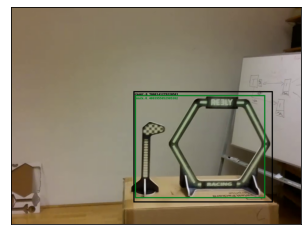

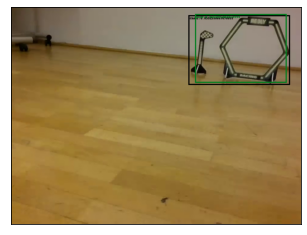

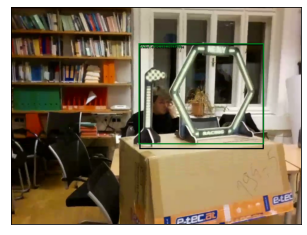

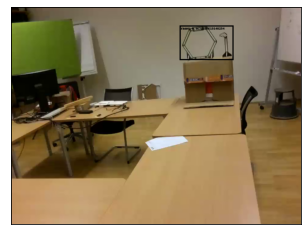

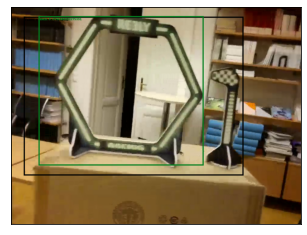

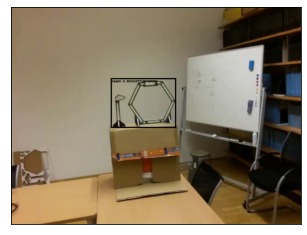

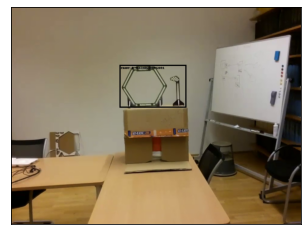

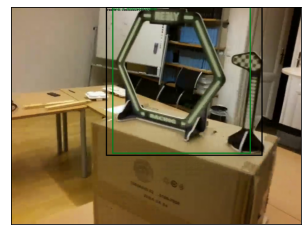

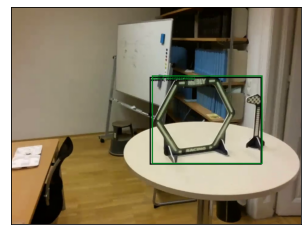

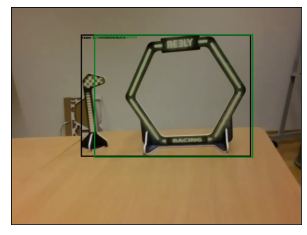

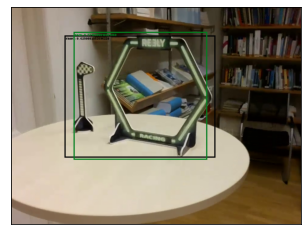

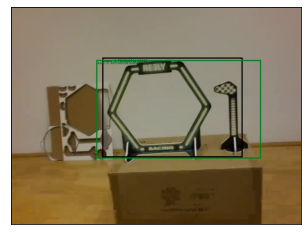

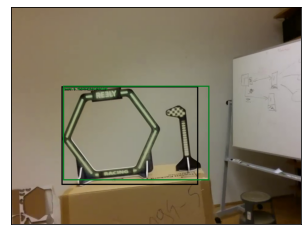

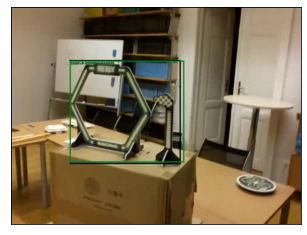

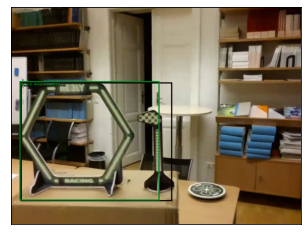

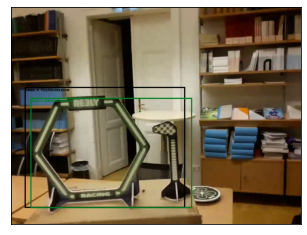

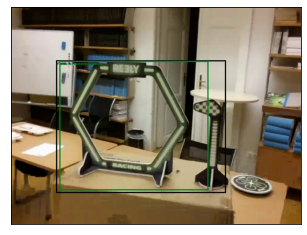

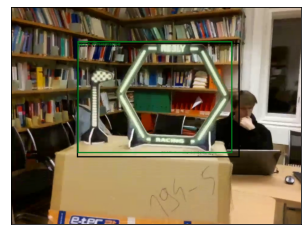

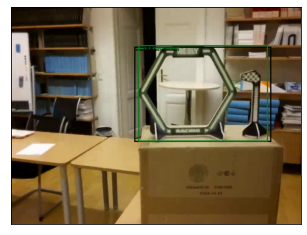

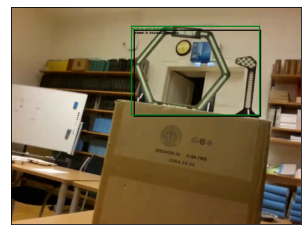

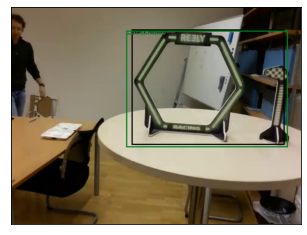

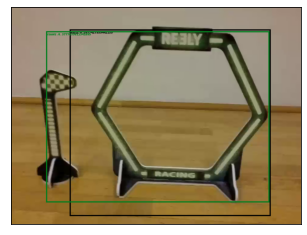

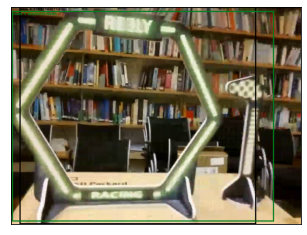

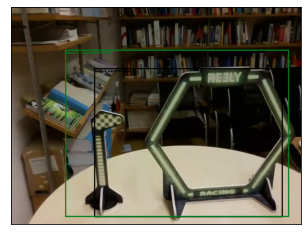

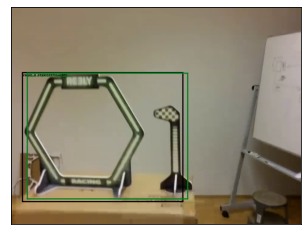

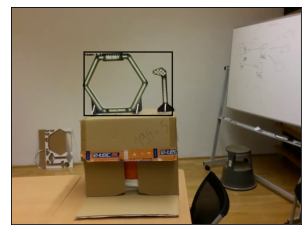

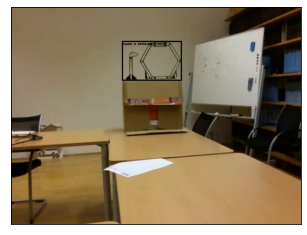

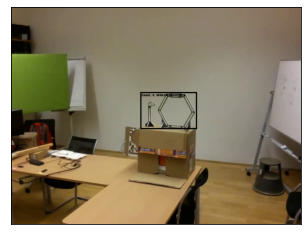

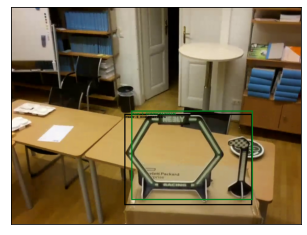

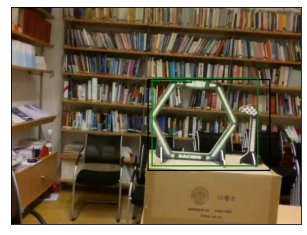

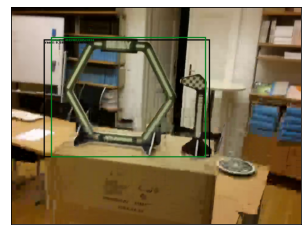

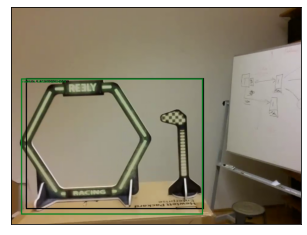

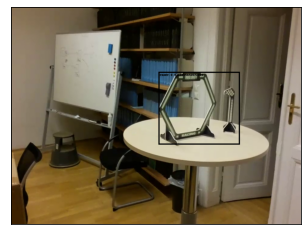

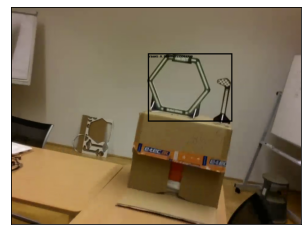

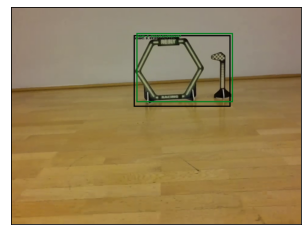

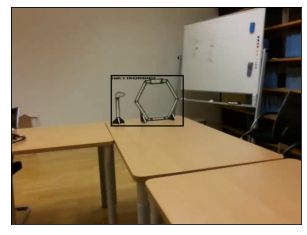

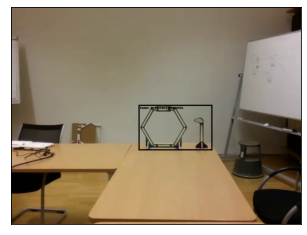

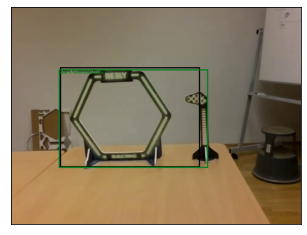

In [ ]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import os
from os import listdir
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from enum import Enum
from torchvision.utils import draw_bounding_boxes


plt.rcParams["savefig.bbox"] = "tight"
images_dir = Path(PATH_TO_TEST, "images")
score_threshold = 0.2


class Label(Enum):
    FRONT = 1
    BACK = 2


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        # img.resize((1000,700), resample=Image.BOX)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def infer(img):
    # Transform image with corresponding wieghts
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    transforms = weights.transforms()
    trans_image = transforms(img)
    # Run inference
    with torch.no_grad():
        prediction = model([trans_image.to(device)])
    return prediction


def extract_labels(prediction):
    # print(prediction)
    length = len(prediction[0]["labels"])
    labels = []
    for i in range(length):
        if prediction[0]["scores"].cpu().numpy()[i] > score_threshold:
            label = Label(prediction[0]["labels"].cpu().numpy()[i]).name
            score = prediction[0]["scores"].cpu().numpy()[i]
            txt = "{}:{}".format(label, score)
            labels.append(txt)
    return labels


model.eval()
for img_name in os.listdir(images_dir):
    # Fetch image
    image = read_image(str(images_dir / img_name))
    # Run inference
    prediction = infer(image)
    print(prediction)
    # Print detection in img
    labels = extract_labels(prediction)
    print(labels)

    show(
        draw_bounding_boxes(
            image,
            boxes=prediction[0]["boxes"][prediction[0]["scores"] > score_threshold],
            labels=labels,
            width=4,
        )
    )


## Estimate Position and Movement

Now to actually extract steering commands from the given camera stream we need to estimate the current position of the drone and calculate movement instructions. To estimate this approximately we used a [formula](https://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo) that uses the real size of the gate compared to the size in the image. In the example below we can see the estimation for various example bounding boxes.

In [ ]:
box0 = [405.6159, 281.9630, 866.6481, 648.6038]  # middle
box1 = [587.3494, 30.2924, 923.1415, 260.5743]  # small
box2 = [425.4016, 126.5008, 836.1588, 472.9669]  # middle
box3 = [558.8442, 64.0435, 736.6177, 178.1957]  # very small
box4 = [42.0816, 35.4822, 769.9694, 559.7094]  # very big
box5 = [330.2679, 238.4673, 546.8438, 402.1519]  # small
whole_image = [0, 0, 960, 720]
image_center = [480, 360]
IMG_CENTER_X = 480
IMG_CENTER_Y = 360

boxes = [box0, box1, box2, box3, box4, box5]


def calc_area(box):
    xtl, ytl, xbr, ybr = box
    area = abs(xtl - xbr) * abs(ytl - ybr)
    print("Area: {}".format(area))
    return area


def calc_height(box):
    xtl, ytl, xbr, ybr = box
    height = abs(ytl - ybr)
    print("Height: {}".format(height))
    return height


def calc_distance(box):
    xtl, ytl, xbr, ybr = box
    f = 2 # mm
    real_height = 300 # mm
    image_height = 720 # px
    object_height = abs(ytl - ybr) # px
    sensor_height = 2.77 # mm
    distance = ((f * real_height * image_height) / (object_height * sensor_height)) * 2 # mm
    print("Distance to object (mm): {:.2f}".format(distance))
    return distance


def calc_center(box):
    xtl, ytl, xbr, ybr = box
    center = [(xtl + xbr) / 2, (ytl + ybr) / 2]
    # print("Center: {}".format(center))
    return center


def calc_movement(box):
    xtl, ytl, xbr, ybr = box
    box_center_x, box_center_y = calc_center(box)
    real_height = 300
    object_height = abs(ytl - ybr)
    scale = object_height / real_height
    if box_center_x > IMG_CENTER_X:
        error = box_center_x - IMG_CENTER_X
        print(f"Move right {error:.0f}px {error*scale:.0f}mm")
    else:
        error = IMG_CENTER_X - box_center_x
        print(f"Move left {error:.0f}px {error*scale:.0f}mm")


for box in boxes:
    calc_distance(box)
    calc_movement(box)
    pass

#calc_distance(prediction[0]["boxes"].cpu().numpy()[0])
#calc_movement(prediction[0]["boxes"].cpu().numpy()[0])

Distance to object (mm): 850.73
Move right 156px 191mm
Distance to object (mm): 1354.48
Move right 275px 211mm
Distance to object (mm): 900.27
Move right 151px 174mm
Distance to object (mm): 2732.43
Move right 168px 64mm
Distance to object (mm): 595.00
Move left 74px 129mm
Distance to object (mm): 1905.58
Move left 41px 23mm


### Test Distance and Movement calculation 

To verify our estimation, we can combined the visualisation and estimation in the below code. When executed, the first 5 images from our dataset are fetched, inferred and the estimation is run. The output then shows for each image the estimated distance and the movement instructions that can be extracted from the image.

Image 1:
Distance to object (mm): 850.73
Move right 156px 191mm
Image 2:
Distance to object (mm): 1354.49
Move right 275px 211mm
Image 3:
Distance to object (mm): 900.27
Move right 151px 174mm
Image 4:
Distance to object (mm): 2732.44
Move right 168px 64mm
Image 5:
Distance to object (mm): 595.00
Move left 74px 129mm


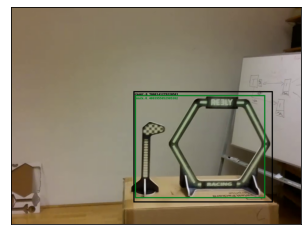

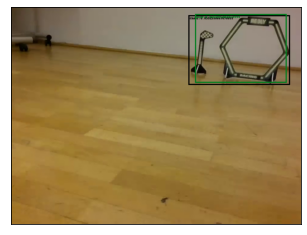

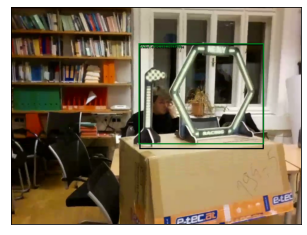

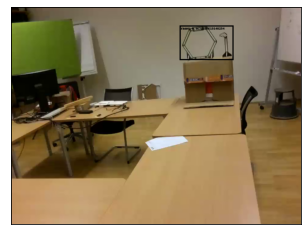

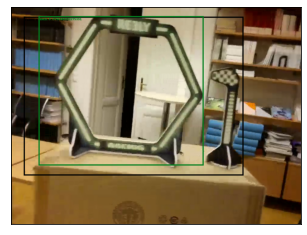

In [ ]:
model.eval()
counter = 0
for img_name in os.listdir(images_dir):
    counter+=1
    if counter < 6:
        # Fetch image
        image = read_image(str(images_dir / img_name))
        # Run inference
        prediction = infer(image)
        # Print detection in img
        labels = extract_labels(prediction)
        boxes=prediction[0]["boxes"][prediction[0]["scores"] > score_threshold]
        show(
            draw_bounding_boxes(
                image,
                boxes=boxes,
                labels=labels,
                width=4,
            )
        )
        print(f"Image {counter}:")
        calc_distance(boxes[0])
        calc_movement(boxes[0])


# ROS Architecture

To actually run our inference on the physical drone we used a dockerized [ROS 2](https://www.ros.org/) architecture. 

There are 2 ROS packages (in seperate Docker images):

1. **tello_ros** (`ros/tello/Dockerfile`): This package contains the [Tello ROS2 driver](https://github.com/clydemcqueen/tello_ros) and is used to communicate with the physical drone.
2. **tello_gate** (`ros/notebook/Dockerfile`): This package contains our custom ROS nodes that are used for inference.

The overall architecture is described best by looking at the available nodes. Note that each node corresponds to a separate container (cf. `docker-compose.yml`) based of one the available images:

* **tello**: To communicate with the drone and get the camera stream, we used a [Tello ROS2 driver](https://github.com/clydemcqueen/tello_ros) that offers the needed functionality. The camera stream is published under the `/image_raw` topic and movement instructions can be sent to the `/tello_action` service.
* **buffer**: The buffer node subscribes ot the `/image_raw` topic and provides a `service` for the most recent image of the camera stream to its clients. Older images that are not fetched by a client (**inference** node) are discarded to save bandwith and processing power.
* **inference**: The inference node is used to run the inference as shown in the previous part of the notebook. It is a `client` and `publisher`. The node connects as a client to the _buffer_ service and fetches the most recent image which is then used for inference. The inference results and movement instructions are then published by the node for further use.
* **replay**: This node is only used to simulate the physical drone by "replaying" a captured camera stream. The node is not used when inference is run on the real drone but allowed us to develop the dependent nodes without access to the physical drone.)


## Run the Project

To run the whole project, one must first extract the `data.tar` to place the images and model data at the correct paths:

```bash
$ pwd
~/ppmrob-project
$ tar -xvf data.tar
```

Now one can simply run `docker compose up` which starts the corresponding docker containers and consequently the ROS nodes. However, to get graphical output it is necessary to start a XServer. On Linux this happens automatically and on Windows the [VcXsrv Windows X Server ](https://sourceforge.net/projects/vcxsrv/) could be used. Then one has to **disable access control** on Linux via `xhost +`, on Windows: 

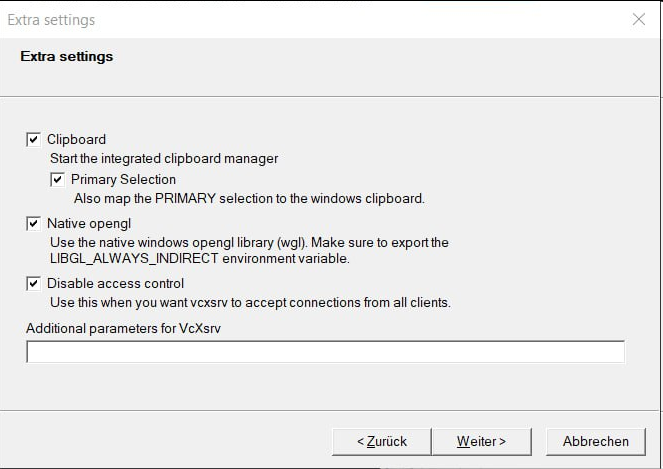


Furthermore, under Windows/macOS remove the `docker-compose.override.yml` file. 

When everything is setup correctly, multiple windows should be opened as shown in the screenshot below. There is a _live stream_ of the drone camera and an _inference stream_ that shows the stream together with the detected objects. The _inference stream_ containes the bounding boxes annotated with the corresponding labels and scores to allow manual verification of the performance. On the _console_ one can see the calculated movement instructions and the distance.

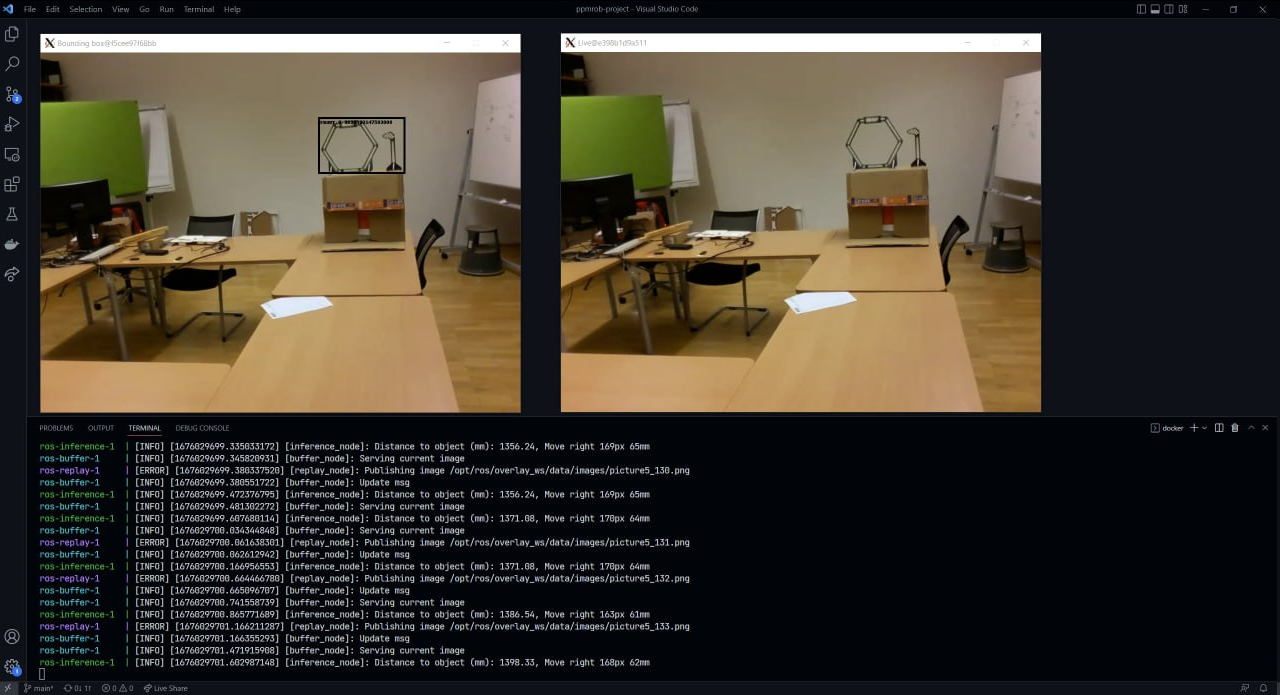

To avoid damage to the drone, we have decided to issue steering commands to the drone manually according to the console output. This can be done by sending commands like this:


```
docker compose run tello ros2 service call /tello_action tello_msgs/TelloAction "{cmd: 'takeoff'}"
```

One can simply replace the `takeoff` command with other supported commands from the Tello drone.